# 介绍 torch 的学习率调整

速效救心丸

### 判断什么时候学习率需要被调整

学习率需要调整主要反映在两种情况上：

1. loss 较小但是一直波动，也就是接近 minimal 但是到不了 minimal
2. loss 较大，与真实的 mininal 相差很大但是即使再训练很多轮也没什么改进

第一种情况反映了学习率略大，第二种反映了学习率略小。学习率过小会导致模型参数困在 local minimal 里面，无法向 global minial 前进；学习率不大会导致模型参数在 global mininal 附近徘徊而无法落入 global minimal。训练过程的不同阶段对于学习率的大小要求是不同的。前期我们希望不被 local minimal 困住，所以学习率要稍微大一些；后期我们要向 global minimal 一点点靠近，所以学习率应该低一些。

这就要求我们在训练过程中动态地调整学习率。

接下来我们的代码部分使用的都是下面的模型和数据集

In [10]:
import torch
import torch.nn as nn

class Toy_Model(nn.Module):
    def __init__(self, input_size, latent_size, output_size, init_lr=0.01):
        super(Toy_Model, self).__init__()
        self.model=nn.Sequential(nn.Linear(input_size,latent_size),
                                    nn.ReLU(),
                                    nn.Linear(latent_size,latent_size),
                                    nn.ReLU(),
                                    nn.Linear(latent_size,output_size),
                                    nn.Sigmoid())
        self.optimizer=torch.optim.Adam(self.parameters(),lr=init_lr)
    
    def forward(self, x):
        return self.model(x)

In [11]:
from sklearn.datasets import fetch_california_housing

data=fetch_california_housing()
X=data.data   # shape (17280,8)
X=torch.FloatTensor(X)
Y=data.target # shape (17280,)
Y=torch.FloatTensor(Y).unsqueeze(-1)

In [12]:
import matplotlib.pyplot as plt

def plot_lr(lr_list):
    plt.plot(lr_list)
    plt.show()

## LambdaLR

使用 LambdaLR 定义的学习率衰减。首先定义一个 epoch 的 Lambda 函数，每次调用 scheduler.step() 函数都会将 lr 乘上这个 Lambda 函数

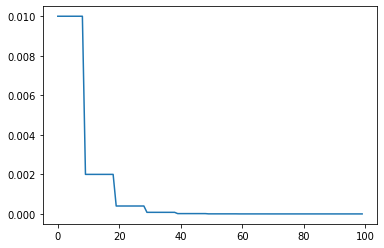

In [14]:
from torch.optim.lr_scheduler import LambdaLR

model=Toy_Model(input_size=X.shape[1],latent_size=10,output_size=1)

lambda_fuc=lambda epoch: 0.2**(epoch//10)
scheduler=LambdaLR(model.optimizer,lr_lambda=lambda_fuc)

lr_list=[]

for epoch in range(100):
    predict_y=model(X)
    loss=torch.nn.functional.mse_loss(predict_y,Y)
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    scheduler.step()
    lr_list.append(model.optimizer.param_groups[0]['lr'])

plot_lr(lr_list)

## StepLR

每经过 step_size 个 epochs 之后通过固定衰减因子 $\gamma$ 来降低学习率

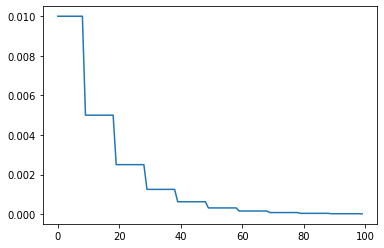

In [16]:
from torch.optim.lr_scheduler import StepLR

model=Toy_Model(input_size=X.shape[1],latent_size=10,output_size=1)

scheduler=StepLR(model.optimizer,step_size=10,gamma=0.5)

lr_list=[]

for epoch in range(100):
    predict_y=model(X)
    loss=torch.nn.functional.mse_loss(predict_y,Y)
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    scheduler.step()
    lr_list.append(model.optimizer.param_groups[0]['lr'])

plot_lr(lr_list)

## MultiStepLR

使用一个 milestones 列表标记固定的 epochs 轮数，到达这些轮数的时候使用 $\gamma$ 进行衰减

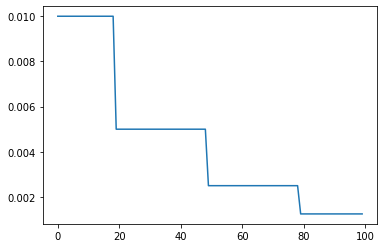

In [17]:
from torch.optim.lr_scheduler import MultiStepLR

model=Toy_Model(input_size=X.shape[1],latent_size=10,output_size=1)

scheduler=MultiStepLR(model.optimizer,milestones=[20,50,80],gamma=0.5)

lr_list=[]

for epoch in range(100):
    predict_y=model(X)
    loss=torch.nn.functional.mse_loss(predict_y,Y)
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    scheduler.step()
    lr_list.append(model.optimizer.param_groups[0]['lr'])

plot_lr(lr_list)

## ExponentialLR

每一轮 epoch 都乘上 $\gamma$ 进行衰减

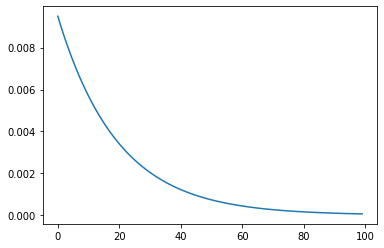

In [18]:
from torch.optim.lr_scheduler import ExponentialLR

model=Toy_Model(input_size=X.shape[1],latent_size=10,output_size=1)

scheduler=ExponentialLR(model.optimizer,gamma=0.95)

lr_list=[]

for epoch in range(100):
    predict_y=model(X)
    loss=torch.nn.functional.mse_loss(predict_y,Y)
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    scheduler.step()
    lr_list.append(model.optimizer.param_groups[0]['lr'])

plot_lr(lr_list)

## ReduceLROnPlateau

当指标停止改进时便开始降低学习率。一旦学习停滞，将学习率降低 2-10 倍之后，模型通常会继续学习。 该调度程序读取一个指标数量，如果一定数量的 epoch 后仍没有改善，则学习率会降低。

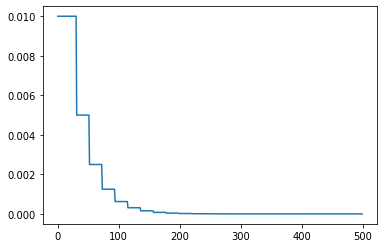

In [23]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model=Toy_Model(input_size=X.shape[1],latent_size=10,output_size=1)

scheduler=ReduceLROnPlateau(model.optimizer,mode='min',patience=20,factor=0.5,threshold=0.0001)

lr_list=[]

for epoch in range(500):
    predict_y=model(X)
    loss=torch.nn.functional.mse_loss(predict_y,Y)
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    scheduler.step(loss)
    lr_list.append(model.optimizer.param_groups[0]['lr'])

plot_lr(lr_list)